In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-globalapprox-barycentric)=
# The barycentric formula

The Lagrange formula {eq}`lagrangeinterp` is useful theoretically but not ideal for computation. For each new value of $x$, all of the cardinal functions $\ell_k$ must be evaluated at $x$, which requires a product of $n$ terms. Thus the total work is $O(n^2)$ for every value of $x$. Moreover, the formula is numerically unstable. An alternative version of the formula improves on both issues.

## Derivation

We again will use the function $\Phi$ from {numref}`Definition {number} <definition-polynomial-indicator>`,

:::{math}
  \Phi(x) = \prod_{j=0}^n (x-t_j).
:::

```{index} ! barycentric weights
```

We also define the **barycentric weights**

:::{math}
:label: baryweight
w_k = \frac{1}{\displaystyle \prod_{\substack{j=0\\j\neq k}}^n (t_k - t_j)} = \frac{1}{\Phi'(x_k)}, \qquad
k = 0,\ldots,n.
:::

The following formula is the key to efficient and stable evaluation of a polynomial interpolant.

```{index} ! barycentric interpolation formula
```

(theorem-barycentric-formula)=
::::{proof:theorem} Barycentric interpolation formula
Given points $(t_k,y_k)$ for $k=0,\ldots,n$ with all the $t_k$ distinct, the unique polynomial of degree $n$ or less that interpolates the points is

:::{math}
  :label: bary2
  p(x) = \frac{\displaystyle \sum_{k=0}^n \, \dfrac{w_k y_k}{x-t_k}  }{\displaystyle\sum_{k=0}^n \, \dfrac{w_k}{x-t_k}}.
:::
::::

::::{proof:proof}
The Lagrange cardinal polynomial {eq}`lagrange` can be written as

:::{math}
  :label: lagrangealt
  \ell_k(x) = \Phi(x) \frac{w_k}{x-t_k},
:::

and thus the interpolating polynomial in {eq}`lagrangeinterp` is

:::{math}
:label: bary1
p(x) = \Phi(x) \sum_{k=0}^n \frac{w_k}{x-t_k} y_k.
:::

Obviously, the constant function $p(x)\equiv 1$ is its own polynomial interpolant on any set of nodes. The uniqueness of the interpolating polynomial, as proved in {numref}`Theorem %s <theorem-polyinterp>`, allows us to plug $y_k=1$ for all $k$ into {eq}`bary1` to obtain

$$
1 = \Phi(x) \sum_{k=0}^n \frac{w_k}{x-t_k}.
$$

This is solved for $\Phi(x)$ and put back into {eq}`bary1` to get {eq}`bary2`.
::::

Equation {eq}`bary2` is certainly an odd-looking way to write a polynomial! Indeed, it is technically undefined when $x$ equals one of the nodes, but in fact, $\lim_{x\to t_k} p(x) = y_k$, so a continuous extension to the nodes is justified. (See [Exercise 3](problem-barycentric-limit).) 

(example-writeoutbary2)=
::::{proof:example}
Let us write out the barycentric formula for the interpolating polynomial for the quadratic case ($n=2$) for {numref}`Example %s <example-ClassicalLagrange>`.  The weights are computed from {eq}`baryweight`:
  
:::{math}
  w_0 = \frac{1}{(t_0-t_1)(t_0-t_2)} = \frac{1}{\left(0-\frac{\pi}{6}\right)
\left(0-\frac{\pi}{3}\right)} = \frac{18}{\pi^2},
:::

and similarly, $w_1 = -36/\pi^2$ and $w_2=18/\pi^2$.

Note that in {eq}`bary2`, any common factor in the weights cancels out without affecting the results. Hence it's a lot easier to use $w_0=w_2=1$ and $w_1=-2$. Then

\begin{align*}
    p(x) & = \frac{\rule[-1.2em]{0pt}{1em} \dfrac{w_0}{x-t_0} y_0  + \dfrac{w_1}{x-t_1} y_1 + \dfrac{w_2}{x-t_2} y_2 }{ \rule{0pt}{1.5em} \dfrac{w_0}{x-t_0} + \dfrac{w_1}{x-t_1} + \dfrac{w_2}{x-t_2}}\\[1.5ex]
    & =\frac{ \rule[-1.2em]{0pt}{1em}\left( \dfrac{1}{x} \right) 0 -  \left( \dfrac{2}{x-\pi/6} \right) \dfrac{1}{\sqrt{3}} + \left( \dfrac{1}{x-\pi/3} \right) \sqrt{3} }{
        \rule{0pt}{1.6em} \dfrac{1}{x} - \dfrac{2}{x-\pi/6} + \dfrac{1}{x-\pi/3}  }.
\end{align*}
  
Further algebraic manipulation could return this expression to the classical Lagrange form derived in {numref}`Example %s <example-ClassicalLagrange>`.
::::

## Implementation

For certain important node distributions, simple formulas for the weights $w_k$ are known. Otherwise, the first task of an implementation is to compute the weights $w_k$, or more conveniently, $w_k^{-1}$.  

We begin with the singleton node set $\{t_0\}$, for which one gets the single weight $w_0=1$. The idea is to grow this singleton into the set of all nodes through a recursive formula. Define $\omega_{k,m-1}$ (for $k< m$) as the inverse of the weight for node $k$ using the set $\{t_0,\ldots,t_{m-1}\}$. Then

$$
\omega_{k,m} = \displaystyle \prod_{\substack{j=0\\j\neq k}}^{m} (t_k - t_j)
     = \omega_{k,m-1} \cdot (t_k-t_{m}), \qquad k=0,1,\ldots,m-1.
$$

A direct application of {eq}`baryweight` can be used to find $\omega_{m,m}$. This process is iterated over $m=1,\ldots,n$ to find $w_k=\omega_{k,n}^{-1}$.

In {numref}`Function {number} <function-polyinterp>` we give an implementation of the barycentric formula for polynomial interpolation. 

```{index} ! Julia; isinf
```

(function-polyinterp)=
````{proof:function} polyinterp
**Polynomial interpolation by the barycentric formula**

```{code-block} julia1
:lineno-start: 1
"""
    polyinterp(t,y)

Construct a callable polynomial interpolant through the points in
vectors `t`,`y` using the barycentric interpolation formula.
"""
function polyinterp(t,y)
    n = length(t)-1
    C = (t[n+1]-t[1]) / 4           # scaling factor to ensure stability
    tc = t/C

    # Adding one node at a time, compute inverses of the weights.
    ω = ones(n+1)
    for m in 0:n-1
        d = tc[1:m+1] .- tc[m+2]    # vector of node differences
        @. ω[1:m+1] *= d            # update previous
        ω[m+2] = prod( -d )         # compute the new one
    end
    w = 1 ./ ω                      # go from inverses to weights

    # This function evaluates the interpolant at given x.
    p = function (x)
        terms = @. w / (x - t)
        if any(isinf.(terms))     # there was division by zero
            # return the node's data value
            idx = findfirst(x.==t)
            f = y[idx]
        else
            f = sum(y.*terms) / sum(terms)
        end
    end
    return p
end
```
````

::::{admonition} About the code
:class: dropdown
As noted in {numref}`Example %s <example-writeoutbary2>`, a common scaling factor in the weights does not affect the barycentric formula {eq}`bary2`. In lines 9--10 this fact is used to rescale the nodes in order to avoid eventual tiny or enormous numbers that could go outside the bounds of double precision.

The return value is a function that evaluates the polynomial interpolant. Within this function, `isinf` is used to detect either `Inf` or `-Inf`, which occurs when $x$ exactly equals one of the nodes. In this event, the corresponding data value is returned.
::::

Computing all $n+1$ weights in {numref}`Function {number} <function-polyinterp>` takes $O(n^2)$ operations. Fortunately, the weights depend only on the nodes, not the data, and once they are known, computing $p(x)$ at a particular value of $x$ takes just $O(n)$ operations.

(demo-barycentric-example)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We show the barycentric formula for values from the function $\sin(e^{2x})$ at equally spaced nodes in $[0,1]$ with $n=3$ and $n=6$.

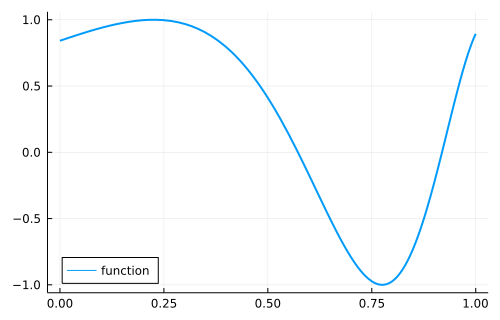

In [2]:
f = x -> sin(exp(2*x))
plot(f,0,1,label="function",legend=:bottomleft)

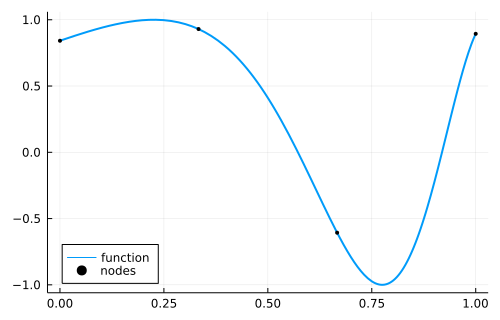

In [3]:
t = (0:3)/3
y = f.(t)
scatter!(t,y,color=:black,label="nodes")

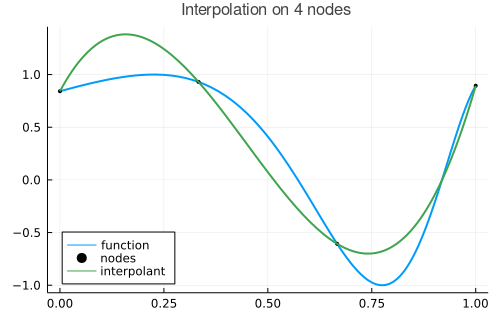

In [4]:
p = FNC.polyinterp(t,y)
plot!(p,0,1,label="interpolant",title="Interpolation on 4 nodes")

The curves must intersect at the interpolation nodes. For $n=6$ the interpolant is noticeably better.

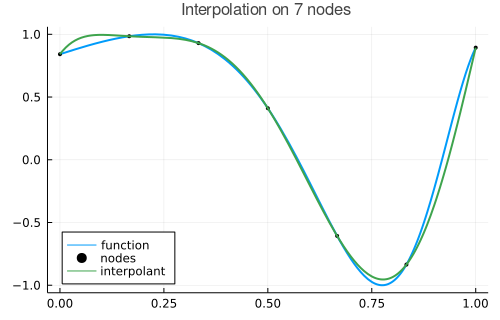

In [5]:
plot(f,0,1,label="function",legend=:bottomleft)
t = (0:6)/6
y = f.(t)
p = FNC.polyinterp(t,y)
scatter!(t,y,color=:black,label="nodes")
plot!(p,0,1,label="interpolant",title="Interpolation on 7 nodes")

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Stability

You might suspect that as the evaluation point $x$ approaches a node $t_k$, subtractive cancellation error will creep into the barycentric formula because of the term $1/(x-t_k)$. While such errors do occur, they turn out not to cause trouble, because the *same* cancellation happens in the numerator and denominator. In fact, the stability of the barycentric formula has been proved, though we do not give the details.

## Exercises

1. ✍ **(a)** Find the barycentric weights for the nodes $t_0=0$, $t_1=1$, $t_2=3$.

    **(b)** Compute the interpolant at $x=2$ for the nodes in part (a) and the data $y_0=-2$, $y_1=2$, $y_2=1$.

2. ✍ For each case of [Exercise 9.1.1](problem-polynomial-lagrange), write out the barycentric form of the interpolating polynomial.

    (problem-barycentric-limit)=
3. ✍  Show using L'Hôpital's rule on {eq}`bary2` that $p(t_i)=y_i$ for all $i=0,\ldots,n$.

4. ⌨ In each case, use {numref}`Function {number}<function-polyinterp>` to interpolate the given function using $n+1$ evenly spaced nodes in the given interval. Plot each interpolant together with the exact function.

    **(a)** $f(x) = \ln (x), \quad n = 2,3,4, \quad x\in [1,10]$

    **(b)** $f(x) = \tanh (x), \quad n = 2,3,4, \quad x \in [0-3,2]$

    **(c)** $f(x) = \cosh (x), \quad n = 2,3,4, \quad x \in [-1,3]$

    **(d)** $f(x) = |x|, \quad n = 3,5,7, \quad x \in [-2,1]$

5. ⌨ Using code from {numref}`Function {number}<function-polyinterp>`, compute the barycentric weights numerically using $n+1$ equally spaced nodes in $[-1,1]$ for $n=30$, $n=60$, and $n=90$. On a single graph, plot $|w_i|$ as a function of $t_i$ on a log-linear scale. (The resulting graphs are an indication of the trouble with equally spaced nodes that is explored in {numref}`section-globalapprox-stability`.)

6. ✍ Derive this fact stated implicitly in {eq}`baryweight`:
    
    $$
    \Phi'(x_k) = \prod_{\substack{j=0\\j\neq k}}^n (t_k - t_j).
    $$

7. ✍ Use {eq}`lagrangealt` to show that if $j\neq k$, 
    
    $$
    \ell_k'(x_j) = \frac{w_k}{w_j(x_j-x_k)}.
    $$